In [1]:
# Implementation of the DRAW network from ArXiv 1502.04623
# With some inspiration from Eric Jang (https://blog.evjang.com/2016/06/understanding-and-implementing.html)
# Using with py27
# ADDING MEANINGFUL USE OF BATCHES

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
'''See: https://www.tensorflow.org/versions/r1.1/get_started/mnist/beginners'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color maps
from sklearn.manifold import TSNE
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Check for GPU
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

devices = get_available_devices()

print(devices)

[u'/device:CPU:0']


In [4]:
def MNIST_row_as_image(row):
    arr1 = []
    for i in range(28):
        arr2 = []
        for j in range(28):
            arr2.append(row[28*i + j])
        arr1.append(arr2)
    return np.array(arr1)

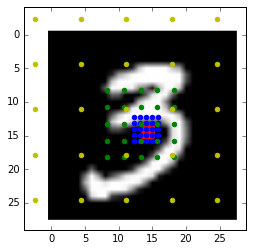

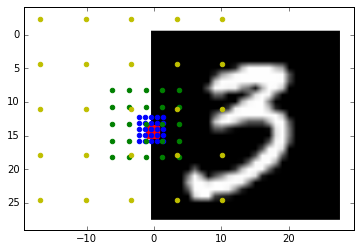

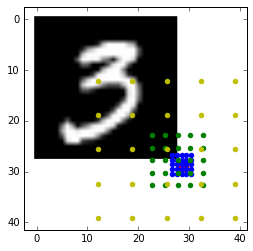

In [5]:
def tf_get_filter_banks(center_coords_dec, sigma_dec, stride_dec, N): # NxN grid of filters
    A,B = 28,28 # For MNIST
    sigma_dec = tf.exp(sigma_dec) # Note: sigma_decoded is the variance not the standard deviation here
    stride_dec = tf.exp(stride_dec) # These start as logs
    stride = stride_dec*float(A-1)/(N-1)
    cx = (center_coords_dec[0]+1)*(float(A+1)/2.0)
    cy = (center_coords_dec[1]+1)*(float(B+1)/2.0)
    center_coords = [cx, cy]
    
    means_of_filtersx = []
    means_of_filtersy = []
    normx = []
    normy = []
    epsilon = 0.0000001
    for i in range(N):
        x_mean = center_coords[0] + (i-N/2-0.5)*stride
        y_mean = center_coords[1] + (i-N/2-0.5)*stride
        means_of_filtersx.append(x_mean)
        means_of_filtersy.append(y_mean)
        normx.append(tf.maximum(tf.reduce_sum([tf.exp(-(ahat-means_of_filtersx[i])**2/(2*(sigma_dec))) for ahat in range(A)]), epsilon))
        normy.append(tf.maximum(tf.reduce_sum([tf.exp(-(bhat-means_of_filtersy[i])**2/(2*(sigma_dec))) for bhat in range(B)]), epsilon))
        
    filter_bank_X = [[(tf.exp(-(a-means_of_filtersx[i])**2/(2*(sigma_dec))))/normx[i] for a in range(A)] for i in range(N)]
    filter_bank_Y = [[(tf.exp(-(b-means_of_filtersy[i])**2/(2*(sigma_dec))))/normy[i] for b in range(B)] for i in range(N)]
    
    return filter_bank_X, filter_bank_Y

def np_get_filter_banks(center_coords_dec, sigma_dec, stride_dec, N): # NxN grid of filters
    A,B = 28,28 # For MNIST
    sigma_dec = np.exp(sigma_dec) # Note: sigma_decoded is the variance not the standard deviation here
    stride_dec = np.exp(stride_dec) # These start as logs
    stride = stride_dec*(float(A-1))/(N-1) 
    cx = (center_coords_dec[0]+1)*(float(A+1)/2.0)
    cy = (center_coords_dec[1]+1)*(float(B+1)/2.0)
    center_coords = [cx, cy]
    
    means_of_filtersx = []
    means_of_filtersy = []
    normx = []
    normy = []
    epsilon = 0.0000001
    for i in range(N):
        x_mean = center_coords[0] + (i-N/2-0.5)*stride
        y_mean = center_coords[1] + (i-N/2-0.5)*stride
        means_of_filtersx.append(x_mean)
        means_of_filtersy.append(y_mean)
        normx.append(np.max([np.sum([np.exp(-(ahat-means_of_filtersx[i])**2/(2*(sigma_dec))) for ahat in range(A)]), epsilon]))
        normy.append(np.max([np.sum([np.exp(-(bhat-means_of_filtersy[i])**2/(2*(sigma_dec))) for bhat in range(B)]), epsilon]))
        
    filter_bank_X = [[(np.exp(-(a-means_of_filtersx[i])**2/(2*(sigma_dec))))/normx[i] for a in range(A)] for i in range(N)]
    filter_bank_Y = [[(np.exp(-(b-means_of_filtersy[i])**2/(2*(sigma_dec))))/normy[i] for b in range(B)] for i in range(N)]
    
    return filter_bank_X, filter_bank_Y, [[x,y] for x in means_of_filtersx for y in means_of_filtersy]

# Test the placement
img = mnist.train.images[10003][:]
plt.figure()
plt.imshow(MNIST_row_as_image(img), cmap = cm.Greys_r)
_, _, means = np_get_filter_banks(center_coords_dec = [0,0], sigma_dec = 0, stride_dec = -3, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
_, _, means = np_get_filter_banks(center_coords_dec = [0,0], sigma_dec = 0, stride_dec = -2, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'b')
_, _, means = np_get_filter_banks(center_coords_dec = [0,0], sigma_dec = 0, stride_dec = -1, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'g')
_, _, means = np_get_filter_banks(center_coords_dec = [0,0], sigma_dec = 0, stride_dec = -0, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'y')
plt.figure()
plt.imshow(MNIST_row_as_image(img), cmap = cm.Greys_r)
_, _, means = np_get_filter_banks(center_coords_dec = [-1,0], sigma_dec = 0, stride_dec = -3, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
_, _, means = np_get_filter_banks(center_coords_dec = [-1,0], sigma_dec = 0, stride_dec = -2, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'b')
_, _, means = np_get_filter_banks(center_coords_dec = [-1,0], sigma_dec = 0, stride_dec = -1, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'g')
_, _, means = np_get_filter_banks(center_coords_dec = [-1,0], sigma_dec = 0, stride_dec = -0, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'y')
plt.show()
plt.figure()
plt.imshow(MNIST_row_as_image(img), cmap = cm.Greys_r)
_, _, means = np_get_filter_banks(center_coords_dec = [1,1], sigma_dec = 0, stride_dec = -3, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
_, _, means = np_get_filter_banks(center_coords_dec = [1,1], sigma_dec = 0, stride_dec = -2, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'b')
_, _, means = np_get_filter_banks(center_coords_dec = [1,1], sigma_dec = 0, stride_dec = -1, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'g')
_, _, means = np_get_filter_banks(center_coords_dec = [1,1], sigma_dec = 0, stride_dec = -0, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'y')

In [6]:
# With some inspiration from Eric Jang: https://blog.evjang.com/2016/06/understanding-and-implementing.html
attention = True
variational = True
num_time_steps = 10
num_units_enc = 50
num_units_dec = 50
num_latents = 10
N_read = 5
N_write = 5
A = 28
B = 28

batch_size = 64

DO_SHARE = False

# Recorded variables

canvas = [None] * num_time_steps
center_coords_decoded = [None] * num_time_steps
sigma_decoded = [None] * num_time_steps
stride_decoded = [None] * num_time_steps
gamma_decoded = [None] * num_time_steps
center_coords_decoded_write = [None] * num_time_steps
sigma_decoded_write = [None] * num_time_steps
stride_decoded_write = [None] * num_time_steps
gamma_decoded_write = [None] * num_time_steps
lms = [None] * num_time_steps
lss = [None] * num_time_steps

# Setting up the computational graph

x = tf.placeholder(shape=[batch_size, A*B],dtype=tf.float32, name = 'x')
canvas_previous = tf.zeros(shape=[batch_size, A*B])

encoder_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_enc)
encoder_state_previous = encoder_cell.zero_state(batch_size, tf.float32)
def encode_step(input_data, network_state):
    with tf.variable_scope("encoder",reuse=DO_SHARE):
        return encoder_cell(inputs = input_data, state = network_state) # This does one cycle of the RNN
        # This uses the __call__ method

decoder_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_dec)
decoder_state_previous = decoder_cell.zero_state(batch_size, tf.float32)
def decode_step(latents, network_state):
    with tf.variable_scope("decoder",reuse=DO_SHARE):
        return decoder_cell(inputs = latents, state = network_state) # This does one cycle of the RNN
        # This uses the __call__ method
    
for t in range(num_time_steps): # Replace with tf.while_loop
    print ("Setting up graph for time-step %i" %t)

    xhat = x-tf.sigmoid(canvas_previous)

    if attention:
        with tf.variable_scope("read_operation",reuse=DO_SHARE):
            read_params = tf.gather(tf.contrib.layers.fully_connected(inputs = decoder_state_previous.h, num_outputs = 5, activation_fn = None), 0)

        center_coords_decoded[t] = [tf.tanh(read_params[0]),tf.tanh(read_params[1])]
        sigma_decoded[t], stride_decoded[t], gamma_decoded[t] = read_params[2], -3.0*tf.sigmoid(read_params[3]-3), read_params[4] 
        # Initializing and range constraining the stride: http://www.wolframalpha.com/input/?i=-3*sigmoid(x-3)
        filter_bank_X, filter_bank_Y = tf_get_filter_banks(center_coords_decoded[t], sigma_decoded[t], stride_decoded[t], N_read)
        
        read_result = [tf.exp(gamma_decoded[t])*tf.matmul(tf.matmul([filter_bank_Y for i in range (batch_size)], tf.reshape(x, [batch_size,A,B])), [tf.transpose(filter_bank_X) for i in range (batch_size)]), tf.exp(gamma_decoded[t])*tf.matmul(tf.matmul([filter_bank_Y  for i in range (batch_size)], tf.reshape(xhat, [batch_size,A,B])), [tf.transpose(filter_bank_X)  for i in range (batch_size)])] 
        # Some annoying list stuff with the filter matrices in here because it wasn't broadcasting properly and batch_matmul doesn't seem to exist anymore
        
        # Update the encoder state
        encoder_state = encode_step(input_data = tf.concat([tf.reshape(read_result, [batch_size,N_read*N_read + N_read*N_read]), tf.reshape(decoder_state_previous.h, [batch_size,num_units_dec])], axis=-1), network_state = encoder_state_previous)
        # Note: encoder_state is the output of the LSTMCell's call method -- first output, then a LSTM state tuple
    else:
        encoder_state = encode_step(input_data = tf.concat([x,xhat], axis = -1), network_state = encoder_state_previous)

    # Sample the latents
    with tf.variable_scope("latents",reuse=DO_SHARE):
        latent_means = tf.contrib.layers.fully_connected(encoder_state[0], num_latents, activation_fn = None)
        latent_stds = tf.exp(tf.contrib.layers.fully_connected(encoder_state[0], num_latents, activation_fn = None))

    samples_without_mean = tf.random_normal([num_latents], mean=0, stddev=1, dtype=tf.float32)  
    sampled_latents = latent_means + (latent_stds * samples_without_mean)

    lms[t] = latent_means
    lss[t] = latent_stds

    # Update the decoder state
    decoder_state = decode_step(latents = sampled_latents, network_state = decoder_state_previous)

    # Write
    if attention:
        with tf.variable_scope("write_operation_attn",reuse=DO_SHARE):
            writing_instruction =  tf.reshape(tf.contrib.layers.fully_connected(decoder_state[0], N_write*N_write, activation_fn = None), [batch_size, N_write,N_write])
            write_params = tf.gather(tf.contrib.layers.fully_connected(inputs = decoder_state[0], num_outputs = 5, activation_fn = None), 0)

        center_coords_decoded_write[t] = [tf.tanh(write_params[0]),tf.tanh(write_params[1])]
        sigma_decoded_write[t], stride_decoded_write[t], gamma_decoded_write[t] = write_params[2], -3.0*tf.sigmoid(write_params[3]-3), write_params[4]
        filter_bank_X_write, filter_bank_Y_write = tf_get_filter_banks(center_coords_decoded_write[t], sigma_decoded_write[t], stride_decoded_write[t], N_write)

        writing_value = tf.exp(-1*gamma_decoded_write[t])*tf.matmul(tf.matmul([tf.transpose(filter_bank_Y_write) for i in range(batch_size)], writing_instruction), [filter_bank_X_write for i in range(batch_size)])
    else:
        with tf.variable_scope("write_operation_noattn",reuse=DO_SHARE):
            writing_instruction = tf.contrib.layers.fully_connected(decoder_state[0], A*B, activation_fn = None)
        writing_value = writing_instruction

    canvas[t] =  canvas_previous + tf.reshape(writing_value, [batch_size,A*B])

    # Cycle
    encoder_state_previous = encoder_state[1]
    decoder_state_previous = decoder_state[1]
    canvas_previous = canvas[t]

    # To turn this on after the first cycle
    DO_SHARE = True

canvas = tf.sigmoid(canvas)
    
# Setting up loss function
print("Setting up loss function...")
epsilon = 0.0000001 # A trick like this was used by Eric Jang for numerical stability, although there with cross-entropy loss -- here it avoids Inf in the log as well
#loss_reconstruction = tf.reduce_mean(tf.squared_difference(canvas[num_time_steps-1],x)) # RMS reconstruction error in the pixel space
loss_reconstruction = 0
loss_latent = 0
o = canvas[-1]
loss_reconstruction = tf.reduce_mean(tf.reduce_sum(-(x*tf.log(o+epsilon) + (1.0-x)*tf.log(1.0-o+epsilon)))) # Cross entropy loss: ~probability of the data
# I think the reason for this is similar to here: https://stats.stackexchange.com/questions/242907/why-use-binary-cross-entropy-for-generator-in-adversarial-networks/242927?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
loss_latent = tf.reduce_mean(tf.reduce_sum([0.5 * tf.reduce_sum(tf.square(lms[t]) + tf.square(lss[t]) - tf.log(tf.square(lms)+epsilon) - 1) for t in range(num_time_steps)]))
if variational:
    relative_weight = 1.0 # Between the reconstruction versus latent KL loss
else:
    relative_weight = 0.0
loss = loss_reconstruction + relative_weight * loss_latent # this includes a manual scaling parameter

Setting up graph for time-step 0
Setting up graph for time-step 1
Setting up graph for time-step 2
Setting up graph for time-step 3
Setting up graph for time-step 4
Setting up graph for time-step 5
Setting up graph for time-step 6
Setting up graph for time-step 7
Setting up graph for time-step 8
Setting up graph for time-step 9
Setting up loss function...


In [7]:
# Setting up the optimizer (we'll have to move this above)
print("Setting up optimizer...")
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
print("Minimizing...")
train_op=optimizer.minimize(loss)

Setting up optimizer...
Minimizing...


In [8]:
# Sanity check on variable shapes
print("All variables...")
for v in tf.all_variables():
    print("\t%s : %s" % (v.name,v.get_shape()))

All variables...
	read_operation/fully_connected/weights:0 : (50, 5)
	read_operation/fully_connected/biases:0 : (5,)
	encoder/lstm_cell/kernel:0 : (150, 200)
	encoder/lstm_cell/bias:0 : (200,)
	latents/fully_connected/weights:0 : (50, 10)
	latents/fully_connected/biases:0 : (10,)
	latents/fully_connected_1/weights:0 : (50, 10)
	latents/fully_connected_1/biases:0 : (10,)
	decoder/lstm_cell/kernel:0 : (60, 200)
	decoder/lstm_cell/bias:0 : (200,)
	write_operation_attn/fully_connected/weights:0 : (50, 25)
	write_operation_attn/fully_connected/biases:0 : (25,)
	write_operation_attn/fully_connected_1/weights:0 : (50, 5)
	write_operation_attn/fully_connected_1/biases:0 : (5,)
	beta1_power:0 : ()
	beta2_power:0 : ()
	read_operation/fully_connected/weights/Adam:0 : (50, 5)
	read_operation/fully_connected/weights/Adam_1:0 : (50, 5)
	read_operation/fully_connected/biases/Adam:0 : (5,)
	read_operation/fully_connected/biases/Adam_1:0 : (5,)
	encoder/lstm_cell/kernel/Adam:0 : (150, 200)
	encoder/lst

In [9]:
# Example run
imgs = []
for b in range(batch_size):
    imgs.append(mnist.train.images[32100+b][:])

sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.initialize_all_variables())

print("Running...")
l, cv, lmsout, lssout = sess.run([loss, canvas, lms, lss], feed_dict = {x:imgs})
print(l)
print(cv)

Running...
176829.0
[[[ 0.4939765   0.49885726  0.50007117 ...,  0.5         0.5         0.5       ]
  [ 0.49482757  0.49901965  0.50008643 ...,  0.5         0.5         0.5       ]
  [ 0.49410766  0.49888229  0.50007296 ...,  0.5         0.5         0.5       ]
  ..., 
  [ 0.49547303  0.49914274  0.50009811 ...,  0.5         0.5         0.5       ]
  [ 0.49578813  0.49920312  0.50011104 ...,  0.49999994  0.5         0.5       ]
  [ 0.49653459  0.49934515  0.50011432 ...,  0.49999994  0.5         0.5       ]]

 [[ 0.51439035  0.5026266   0.50060689 ...,  0.5         0.5         0.5       ]
  [ 0.51719302  0.50314915  0.50065166 ...,  0.5         0.5         0.5       ]
  [ 0.51615667  0.50295317  0.50062907 ...,  0.5         0.5         0.5       ]
  ..., 
  [ 0.51683331  0.50308746  0.50066859 ...,  0.5         0.5         0.5       ]
  [ 0.5189954   0.50348902  0.50071859 ...,  0.49999994  0.5         0.5       ]
  [ 0.52266157  0.50416958  0.50074357 ...,  0.49999994  0.5         0.

Untrained model...


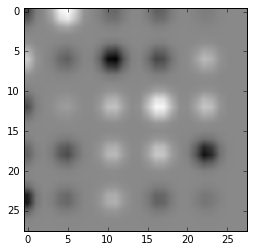

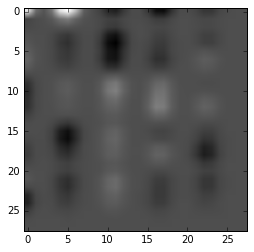

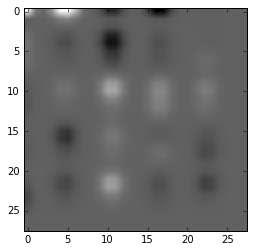

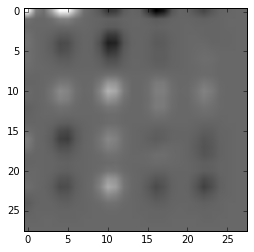

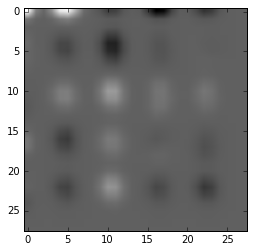

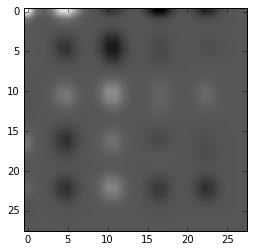

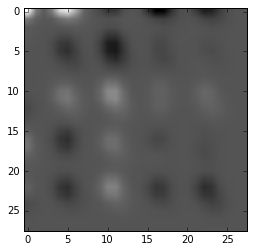

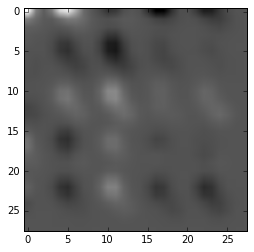

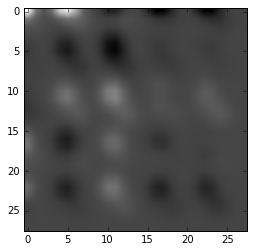

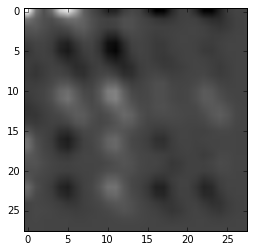

In [10]:
print("Untrained model...")
for t in range(len(cv)):
    c = cv[t][-1] # Last batch for each time step
    c_img = MNIST_row_as_image(c.tolist())
    plt.figure()
    plt.imshow(c_img, cmap = cm.Greys_r)

In [11]:
print("Running...")

l, cv, lmsout, lssout, ccd, sig, stri, ccdw, sigw, striw = sess.run([loss, canvas, lms, lss, center_coords_decoded, sigma_decoded, stride_decoded, center_coords_decoded_write, sigma_decoded_write, stride_decoded_write], feed_dict = {x:imgs})

Running...


Untrained model...


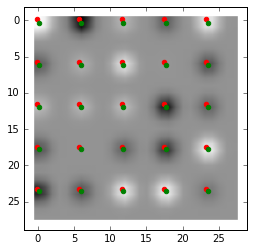

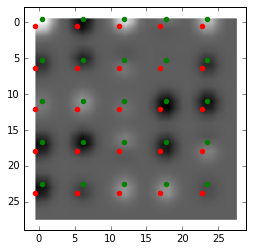

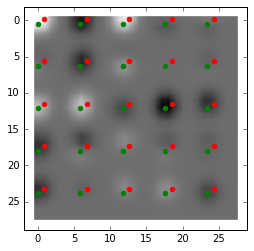

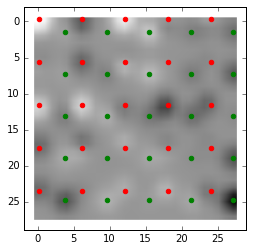

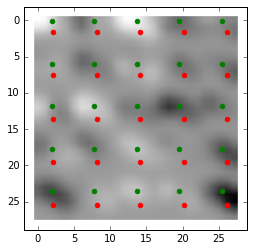

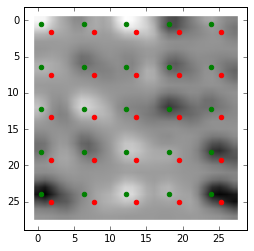

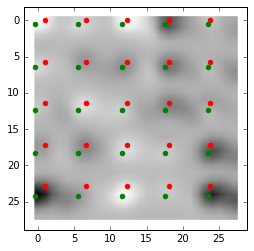

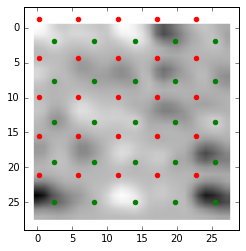

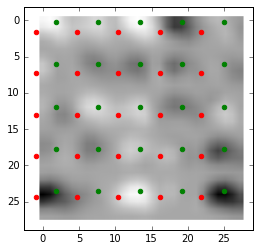

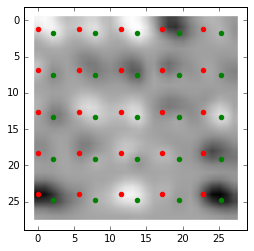

In [ ]:
print("Untrained model...")
for t in range(len(cv)):
    c = cv[t][-1] # Last batch of each time step
    c_img = MNIST_row_as_image(c.tolist())
    plt.figure()
    plt.imshow(c_img, cmap = cm.Greys_r)

    filter_bank_X, filter_bank_Y, means = np_get_filter_banks(center_coords_dec = ccd[t], sigma_dec = sig[t], stride_dec = stri[t], N = N_read)
    filter_bank_Xw, filter_bank_Yw, meansw = np_get_filter_banks(center_coords_dec = ccdw[t], sigma_dec = sigw[t], stride_dec = striw[t], N = N_write)
    if attention:
        scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
        scat2 = plt.scatter([m[0] for m in meansw], [m[1] for m in meansw], color = 'g')
    plt.show()

Training...
Attention: True
Examples 0


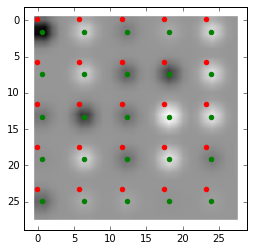

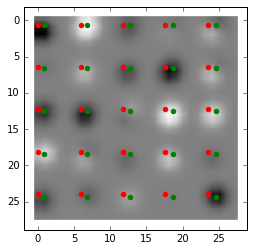

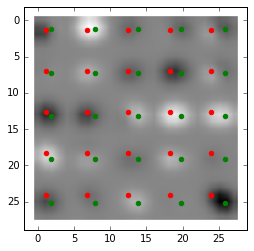

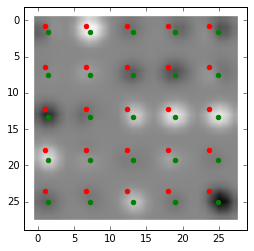

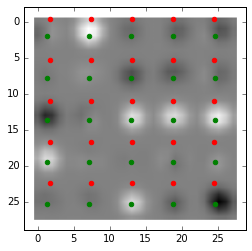

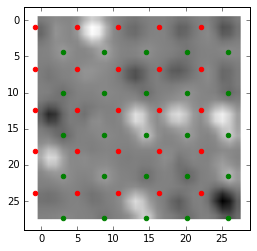

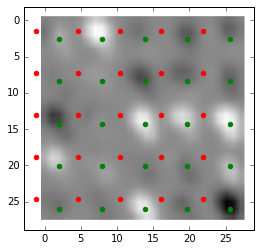

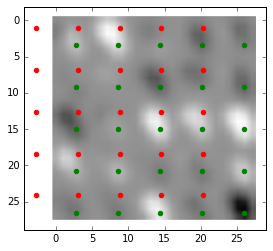

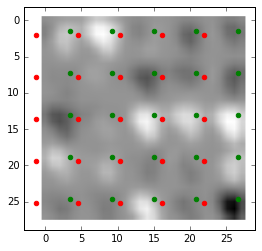

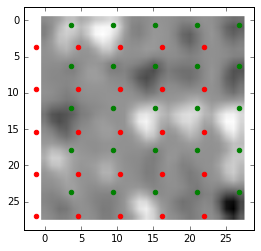

	Loss 184432.187500
Examples 1
	Loss 172607.953125
Examples 2
	Loss 165849.812500
Examples 3
	Loss 159679.109375
Examples 4
	Loss 145891.218750
Examples 5
	Loss 139467.406250
Examples 6
	Loss 133416.015625
Examples 7
	Loss 126569.484375
Examples 8
	Loss 124088.039062
Examples 9
	Loss 118902.375000
Examples 10
	Loss 115147.789062
Examples 11
	Loss 110365.742188
Examples 12
	Loss 107569.343750
Examples 13
	Loss 97289.546875
Examples 14
	Loss 101796.171875
Examples 15
	Loss 109400.492188
Examples 16
	Loss 91892.476562
Examples 17
	Loss 92529.617188
Examples 18
	Loss 86132.671875
Examples 19
	Loss 82571.046875
Examples 20


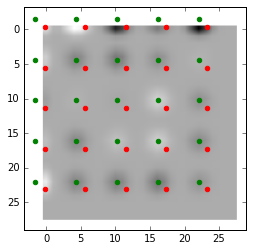

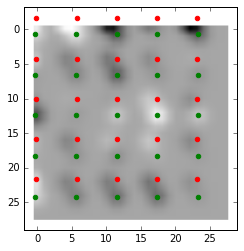

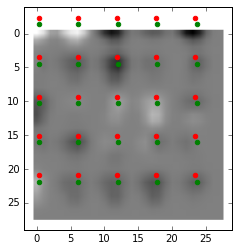

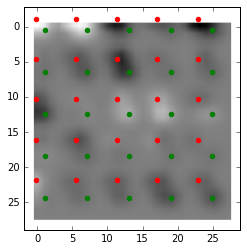

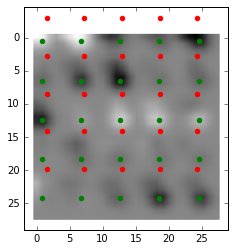

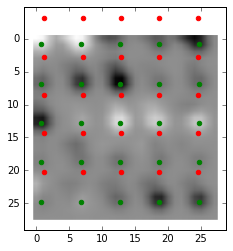

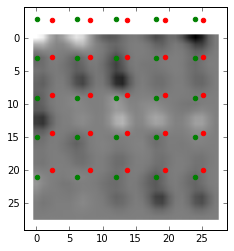

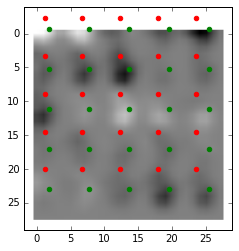

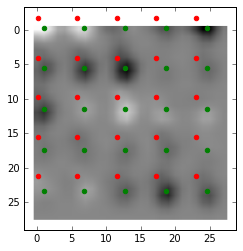

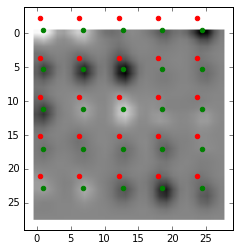

	Loss 83205.382812
Examples 21
	Loss 76338.156250
Examples 22
	Loss 77540.109375
Examples 23
	Loss 77530.226562
Examples 24
	Loss 74965.398438
Examples 25
	Loss 72555.796875
Examples 26
	Loss 74007.453125
Examples 27
	Loss 69925.546875
Examples 28
	Loss 68534.546875
Examples 29
	Loss 65670.250000
Examples 30
	Loss 69373.359375
Examples 31
	Loss 64918.242188
Examples 32
	Loss 66761.203125
Examples 33
	Loss 65478.800781
Examples 34
	Loss 60437.765625
Examples 35
	Loss 61115.292969
Examples 36
	Loss 60680.679688
Examples 37
	Loss 61369.750000
Examples 38
	Loss 59282.867188
Examples 39
	Loss 60655.886719
Examples 40


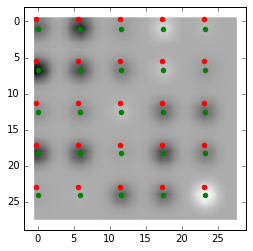

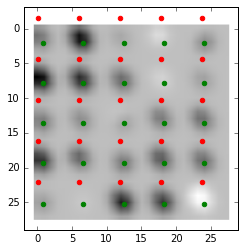

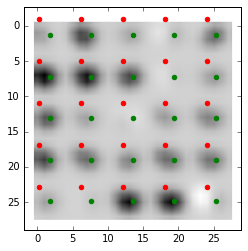

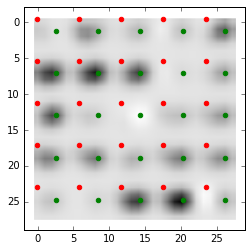

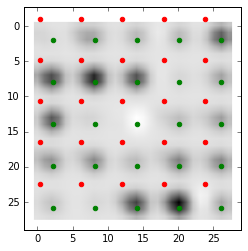

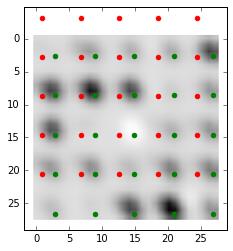

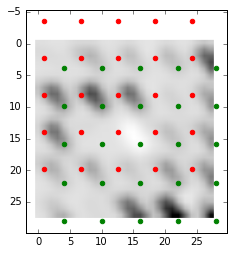

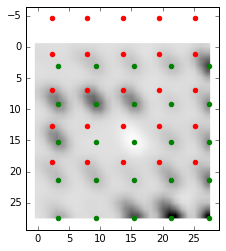

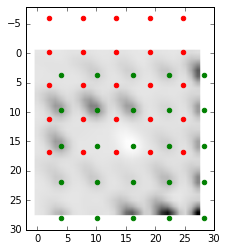

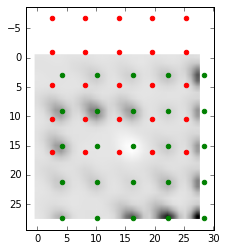

	Loss 59782.914062
Examples 41
	Loss 60698.781250
Examples 42
	Loss 57640.121094
Examples 43
	Loss 56230.011719
Examples 44
	Loss 55402.570312
Examples 45
	Loss 56870.320312
Examples 46
	Loss 55722.570312
Examples 47
	Loss 55332.742188
Examples 48
	Loss 52071.039062
Examples 49
	Loss 52267.968750
Examples 50
	Loss 49830.414062
Examples 51
	Loss 47446.671875
Examples 52
	Loss 49121.304688
Examples 53
	Loss 44410.734375
Examples 54
	Loss 43028.449219
Examples 55
	Loss 40971.070312
Examples 56
	Loss 38156.023438
Examples 57
	Loss 37997.625000
Examples 58
	Loss 35295.570312
Examples 59
	Loss 33127.851562
Examples 60


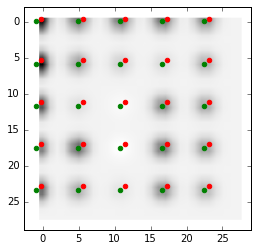

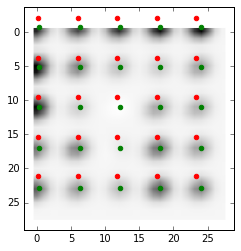

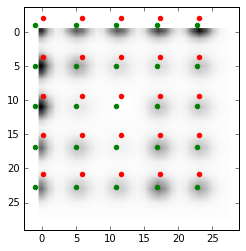

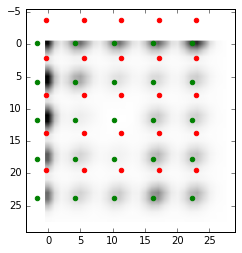

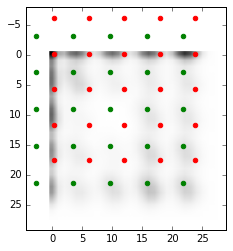

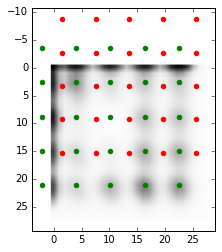

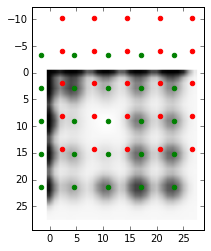

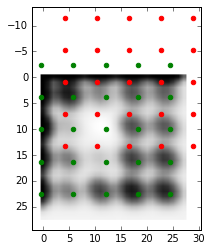

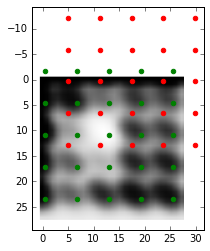

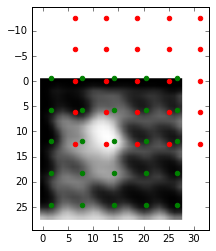

	Loss 33744.156250
Examples 61
	Loss 32225.238281
Examples 62
	Loss 30675.341797
Examples 63
	Loss 29624.869141
Examples 64
	Loss 30838.455078
Examples 65
	Loss 28916.074219
Examples 66
	Loss 27697.937500
Examples 67
	Loss 28551.824219
Examples 68
	Loss 33810.910156
Examples 69
	Loss 28801.876953
Examples 70
	Loss 30386.052734
Examples 71
	Loss 30184.875000
Examples 72
	Loss 25587.410156
Examples 73
	Loss 27207.625000
Examples 74
	Loss 26833.324219
Examples 75
	Loss 25448.199219
Examples 76
	Loss 27501.425781
Examples 77
	Loss 25861.353516
Examples 78
	Loss 25904.140625
Examples 79
	Loss 26061.160156
Examples 80


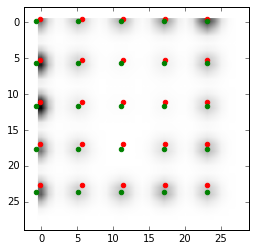

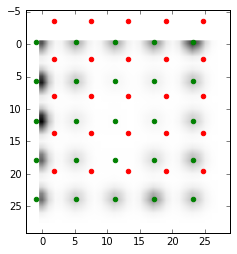

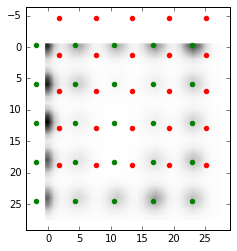

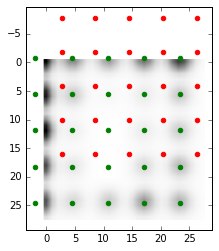

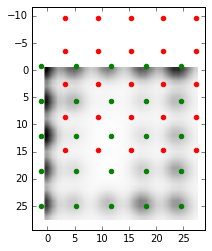

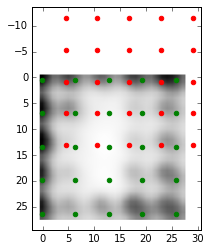

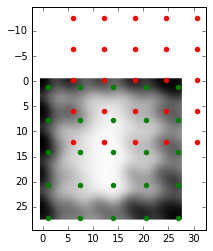

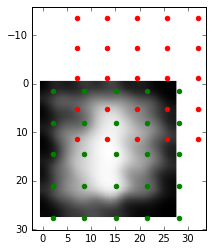

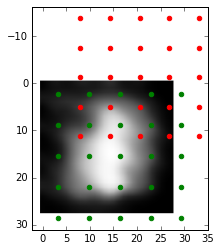

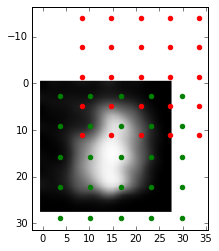

	Loss 25060.867188
Examples 81
	Loss 23388.978516
Examples 82
	Loss 24775.212891
Examples 83
	Loss 24596.890625
Examples 84
	Loss 23187.929688
Examples 85
	Loss 23682.087891
Examples 86
	Loss 23829.744141
Examples 87
	Loss 24271.152344
Examples 88
	Loss 23217.167969
Examples 89
	Loss 24393.191406
Examples 90
	Loss 23787.335938
Examples 91
	Loss 23466.490234
Examples 92
	Loss 22864.636719
Examples 93
	Loss 23381.654297
Examples 94
	Loss 22250.398438
Examples 95
	Loss 22756.539062
Examples 96
	Loss 22221.640625
Examples 97
	Loss 24046.201172
Examples 98
	Loss 23761.968750
Examples 99
	Loss 22414.324219
Examples 100


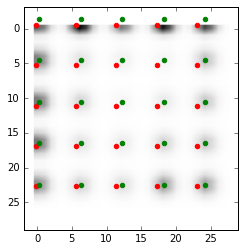

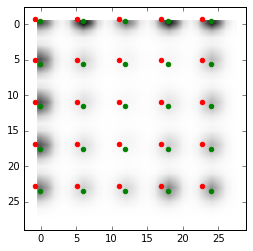

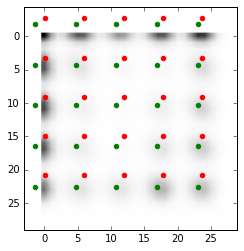

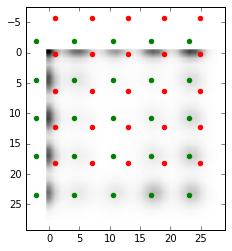

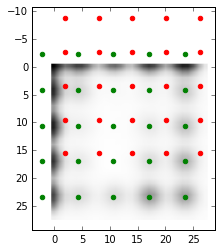

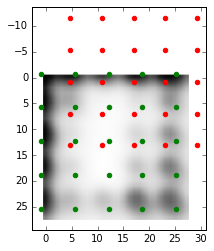

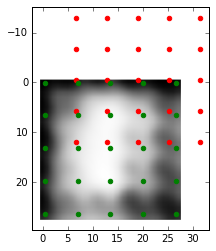

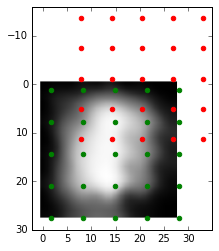

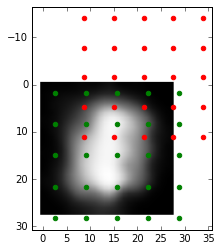

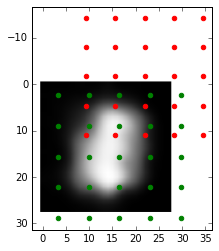

	Loss 22599.472656
Examples 101
	Loss 23588.408203
Examples 102
	Loss 21729.218750
Examples 103
	Loss 22003.117188
Examples 104
	Loss 23877.759766
Examples 105
	Loss 22654.230469
Examples 106
	Loss 20970.179688
Examples 107
	Loss 21674.447266
Examples 108
	Loss 22247.964844
Examples 109
	Loss 21705.054688
Examples 110
	Loss 21578.328125
Examples 111
	Loss 20673.960938
Examples 112
	Loss 20710.939453
Examples 113
	Loss 21954.076172
Examples 114
	Loss 20286.212891
Examples 115
	Loss 21711.871094
Examples 116
	Loss 21334.609375
Examples 117
	Loss 21422.933594
Examples 118
	Loss 20060.841797
Examples 119
	Loss 21039.007812
Examples 120


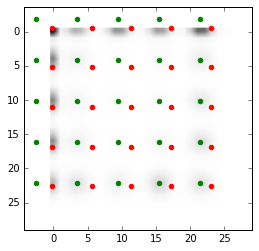

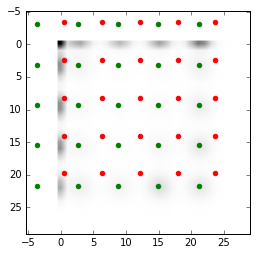

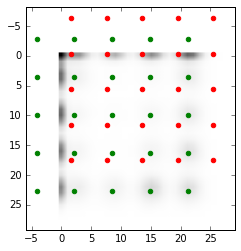

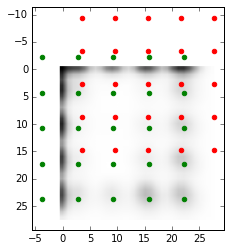

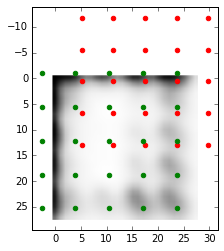

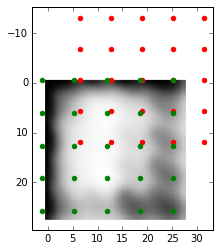

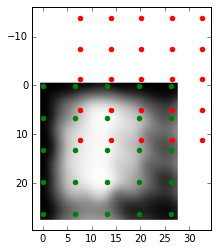

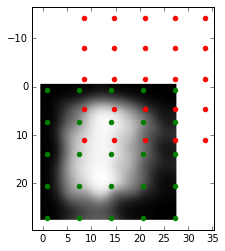

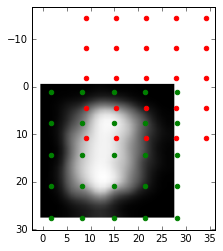

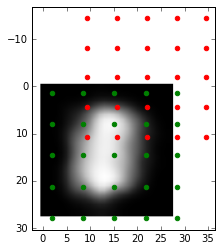

	Loss 20019.345703
Examples 121
	Loss 20661.000000
Examples 122
	Loss 20299.824219
Examples 123
	Loss 20968.136719
Examples 124
	Loss 20801.322266
Examples 125
	Loss 20551.769531
Examples 126
	Loss 20003.890625
Examples 127
	Loss 19669.220703
Examples 128
	Loss 19183.089844
Examples 129
	Loss 19806.542969
Examples 130
	Loss 20430.824219
Examples 131
	Loss 19371.574219
Examples 132
	Loss 19915.048828
Examples 133
	Loss 19733.332031
Examples 134
	Loss 18776.132812
Examples 135
	Loss 19387.603516
Examples 136
	Loss 19429.654297
Examples 137
	Loss 19491.878906
Examples 138
	Loss 18942.363281
Examples 139
	Loss 19143.085938
Examples 140


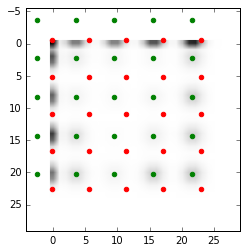

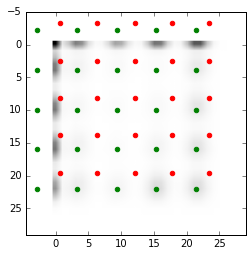

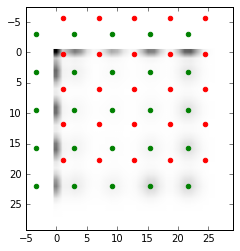

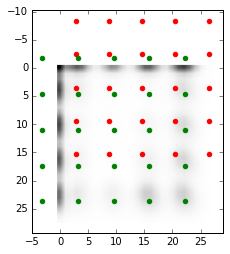

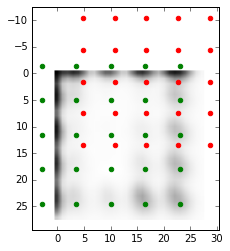

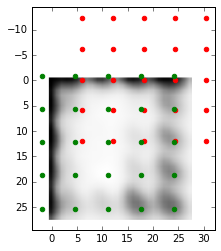

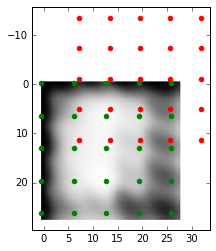

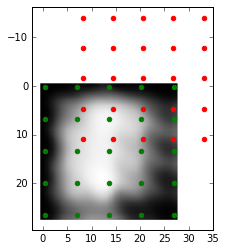

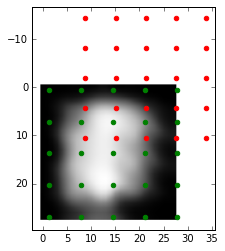

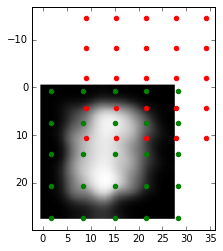

	Loss 19798.181641
Examples 141
	Loss 20365.398438
Examples 142
	Loss 20395.257812
Examples 143
	Loss 19015.066406
Examples 144
	Loss 20287.214844
Examples 145
	Loss 19859.097656
Examples 146
	Loss 18658.843750
Examples 147
	Loss 18982.009766
Examples 148
	Loss 18411.160156
Examples 149
	Loss 19289.947266
Examples 150
	Loss 19149.906250
Examples 151
	Loss 18901.464844
Examples 152
	Loss 18692.238281
Examples 153
	Loss 19714.273438
Examples 154
	Loss 18013.970703
Examples 155
	Loss 19943.498047
Examples 156
	Loss 18217.517578
Examples 157
	Loss 18476.828125
Examples 158
	Loss 18556.000000
Examples 159
	Loss 18179.279297
Examples 160


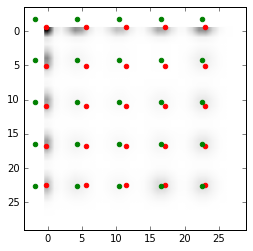

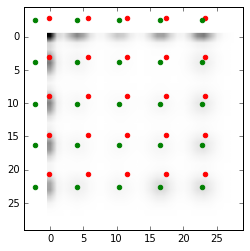

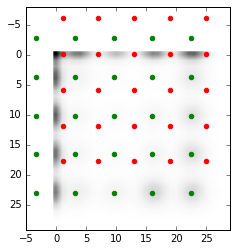

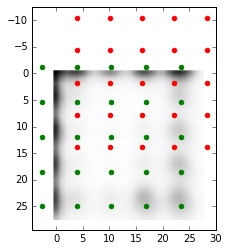

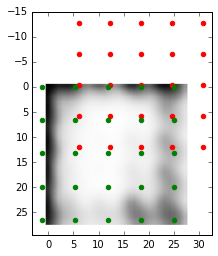

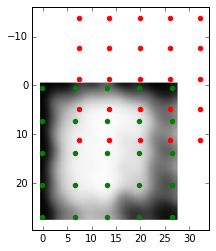

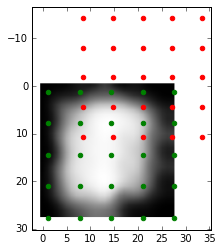

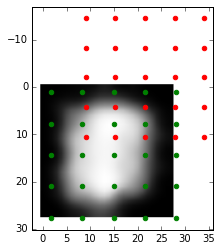

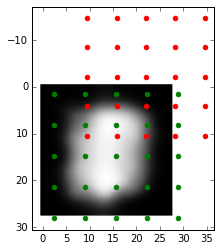

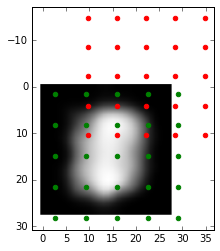

	Loss 18175.316406
Examples 161
	Loss 17752.910156
Examples 162
	Loss 18062.564453
Examples 163
	Loss 18704.791016
Examples 164
	Loss 18486.304688
Examples 165
	Loss 18604.285156
Examples 166
	Loss 18414.847656
Examples 167
	Loss 18438.230469
Examples 168
	Loss 17678.515625
Examples 169
	Loss 17339.519531
Examples 170
	Loss 17593.285156
Examples 171
	Loss 17979.404297
Examples 172
	Loss 17379.396484
Examples 173
	Loss 17959.060547
Examples 174
	Loss 18374.408203
Examples 175
	Loss 18031.939453
Examples 176
	Loss 17579.833984
Examples 177
	Loss 18419.414062
Examples 178
	Loss 17706.630859
Examples 179
	Loss 17968.976562
Examples 180


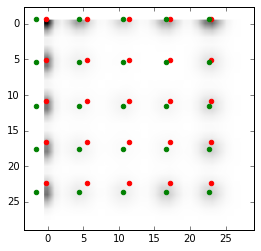

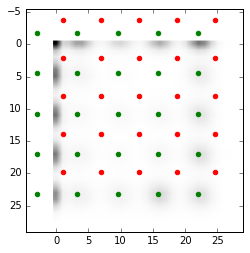

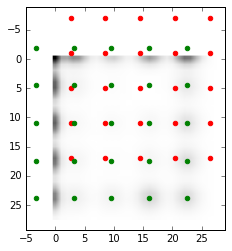

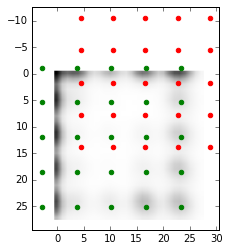

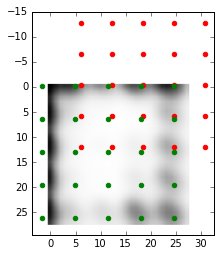

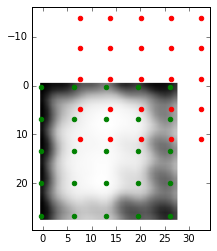

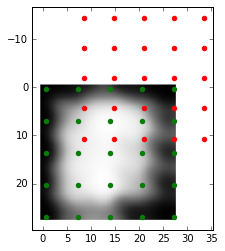

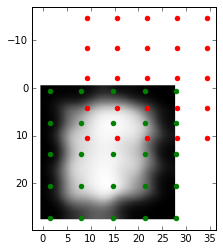

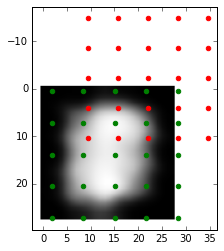

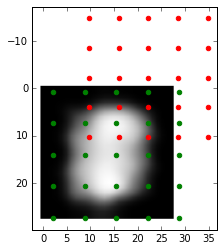

	Loss 17893.925781
Examples 181
	Loss 16694.896484
Examples 182
	Loss 18546.726562
Examples 183
	Loss 17399.777344
Examples 184
	Loss 17110.818359
Examples 185
	Loss 17551.621094
Examples 186
	Loss 17473.269531
Examples 187
	Loss 17367.927734
Examples 188
	Loss 17755.408203
Examples 189
	Loss 17423.445312
Examples 190
	Loss 17642.572266
Examples 191
	Loss 17079.761719
Examples 192
	Loss 17870.699219
Examples 193
	Loss 18452.746094
Examples 194
	Loss 16825.398438
Examples 195
	Loss 17347.818359
Examples 196
	Loss 17262.736328
Examples 197
	Loss 17373.253906
Examples 198
	Loss 16724.855469
Examples 199
	Loss 17201.482422
Examples 200


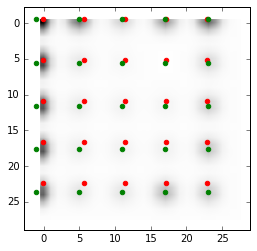

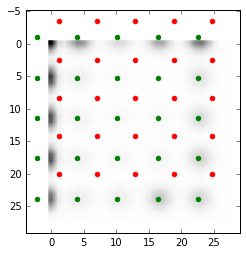

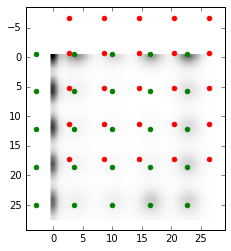

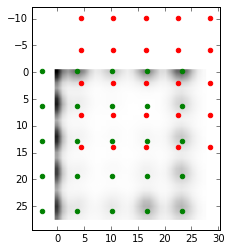

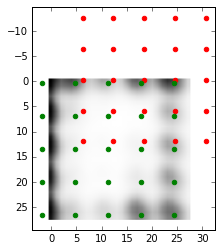

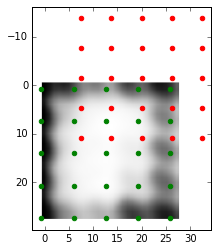

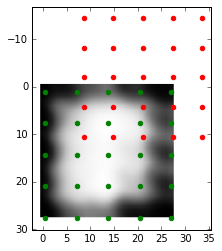

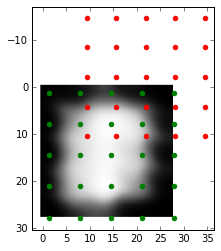

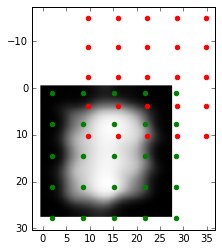

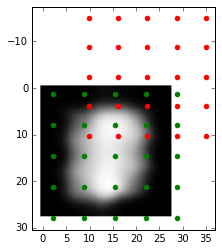

	Loss 17515.826172
Examples 201
	Loss 16654.476562
Examples 202
	Loss 16927.000000
Examples 203
	Loss 17435.128906
Examples 204
	Loss 17211.722656
Examples 205
	Loss 17153.699219
Examples 206
	Loss 17209.958984
Examples 207
	Loss 17020.562500
Examples 208
	Loss 16927.435547
Examples 209
	Loss 17118.968750
Examples 210
	Loss 16836.445312
Examples 211
	Loss 16972.474609
Examples 212
	Loss 16533.554688
Examples 213
	Loss 17439.904297
Examples 214
	Loss 16262.802734
Examples 215
	Loss 16402.611328
Examples 216
	Loss 17299.097656
Examples 217
	Loss 16688.597656
Examples 218
	Loss 16012.820312
Examples 219
	Loss 16791.515625
Examples 220


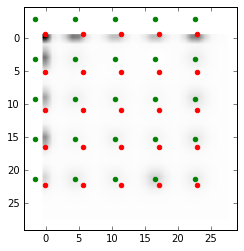

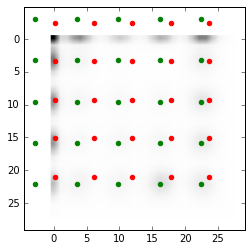

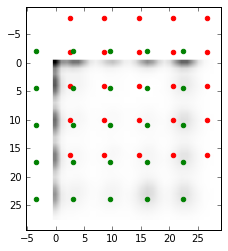

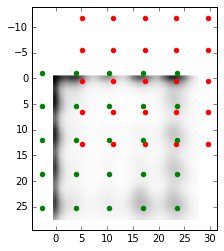

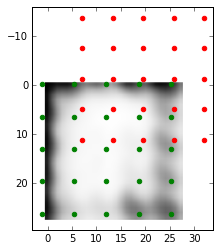

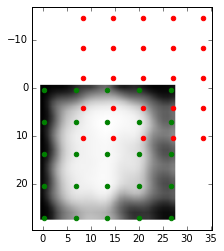

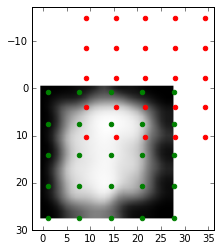

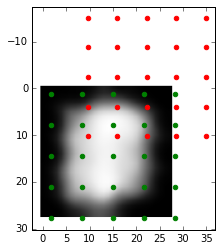

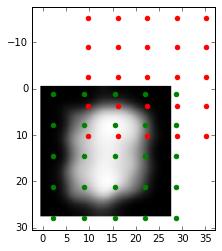

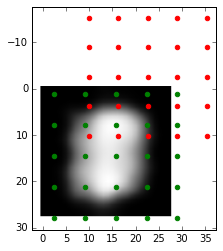

	Loss 16798.009766
Examples 221
	Loss 16731.896484
Examples 222
	Loss 15851.203125
Examples 223
	Loss 15908.981445
Examples 224
	Loss 16279.610352
Examples 225
	Loss 17097.820312
Examples 226
	Loss 16546.769531
Examples 227
	Loss 16056.904297
Examples 228
	Loss 16740.804688
Examples 229
	Loss 16413.960938
Examples 230
	Loss 16439.111328
Examples 231
	Loss 16289.601562
Examples 232
	Loss 17093.705078
Examples 233
	Loss 16474.330078
Examples 234
	Loss 16105.244141
Examples 235
	Loss 15834.603516
Examples 236
	Loss 16338.372070
Examples 237
	Loss 15956.859375
Examples 238
	Loss 16594.632812
Examples 239
	Loss 16585.291016
Examples 240


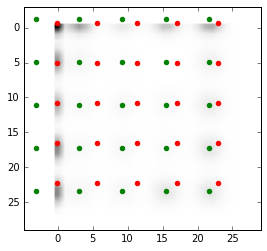

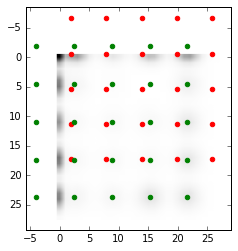

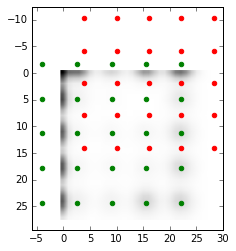

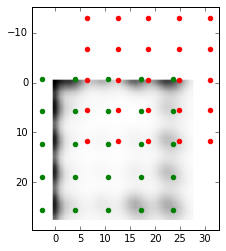

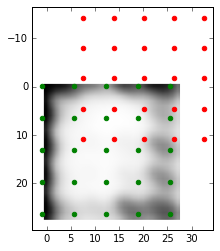

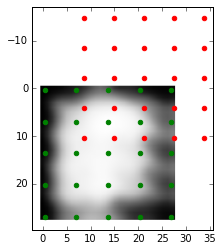

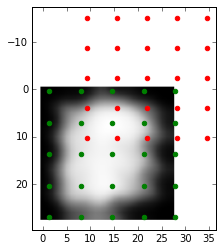

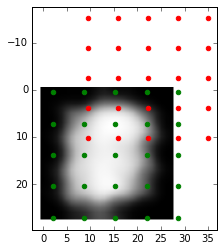

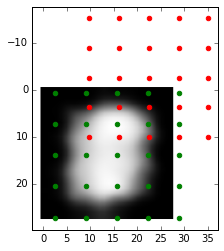

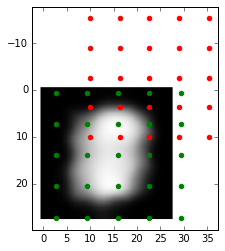

	Loss 16446.972656
Examples 241
	Loss 17275.626953
Examples 242
	Loss 16326.358398
Examples 243
	Loss 17002.873047
Examples 244
	Loss 15646.689453
Examples 245
	Loss 16179.373047
Examples 246
	Loss 16105.939453
Examples 247
	Loss 16383.994141
Examples 248
	Loss 16168.537109
Examples 249
	Loss 15882.081055
Examples 250
	Loss 16501.626953
Examples 251
	Loss 15727.750000
Examples 252
	Loss 16151.805664
Examples 253
	Loss 16228.892578
Examples 254
	Loss 16213.923828
Examples 255
	Loss 15761.548828
Examples 256
	Loss 15839.909180
Examples 257
	Loss 16059.106445
Examples 258
	Loss 15640.809570
Examples 259
	Loss 15824.783203
Examples 260


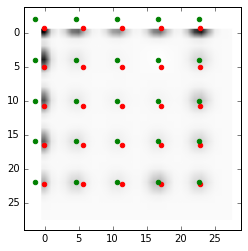

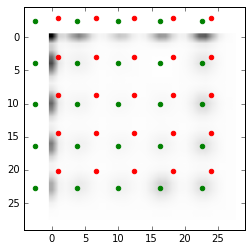

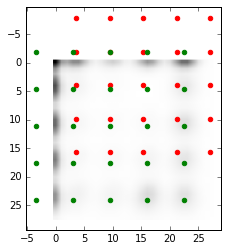

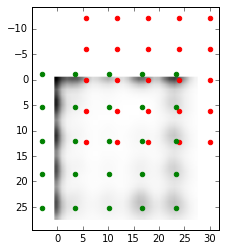

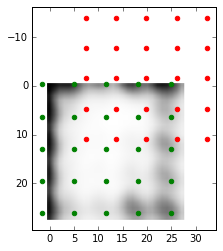

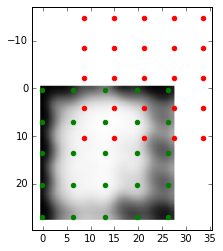

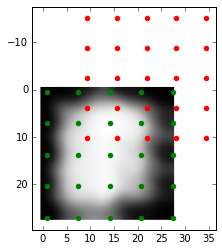

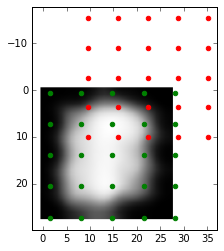

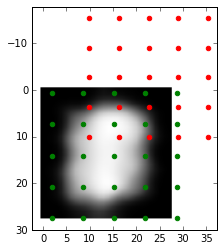

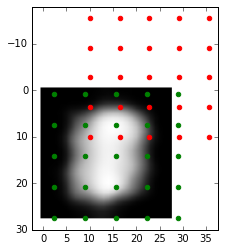

	Loss 16215.356445
Examples 261
	Loss 15970.064453
Examples 262
	Loss 16472.177734
Examples 263
	Loss 15952.211914
Examples 264
	Loss 16115.300781
Examples 265
	Loss 16498.722656
Examples 266
	Loss 16223.956055
Examples 267
	Loss 15780.154297
Examples 268
	Loss 15797.345703
Examples 269
	Loss 15303.012695
Examples 270
	Loss 15416.679688
Examples 271
	Loss 15659.922852
Examples 272
	Loss 15890.959961
Examples 273
	Loss 15414.557617
Examples 274
	Loss 15788.493164
Examples 275
	Loss 15320.942383
Examples 276
	Loss 15754.625000
Examples 277
	Loss 15325.406250
Examples 278
	Loss 15755.494141
Examples 279
	Loss 15610.276367
Examples 280


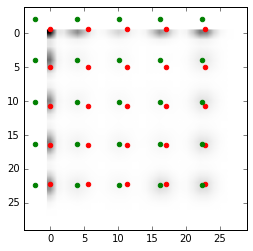

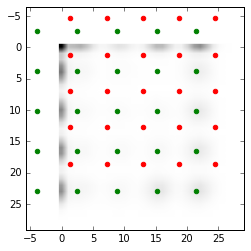

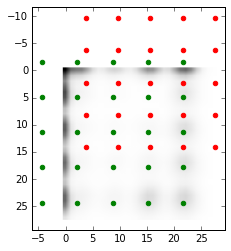

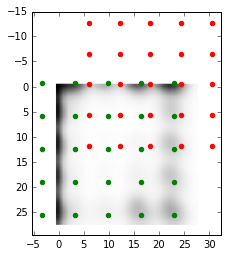

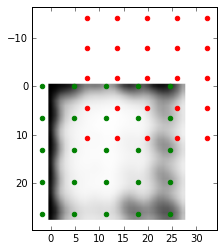

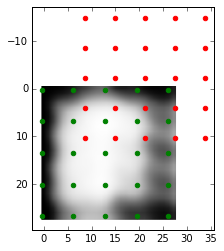

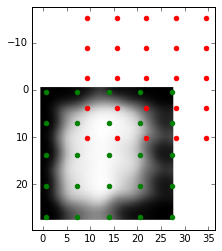

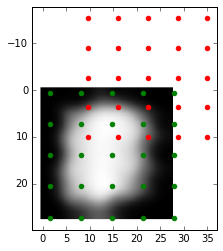

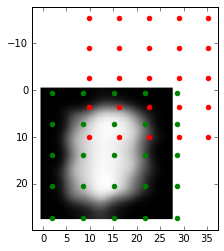

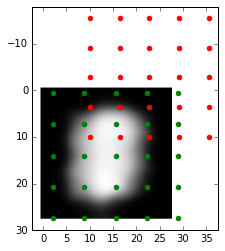

	Loss 15300.181641
Examples 281
	Loss 15593.134766
Examples 282
	Loss 15762.054688
Examples 283
	Loss 15419.922852
Examples 284
	Loss 15552.088867
Examples 285
	Loss 16032.955078
Examples 286
	Loss 15752.233398
Examples 287
	Loss 15860.037109
Examples 288
	Loss 16169.460938
Examples 289
	Loss 16076.179688
Examples 290
	Loss 15139.324219
Examples 291
	Loss 15300.846680
Examples 292
	Loss 15781.608398
Examples 293
	Loss 16027.114258
Examples 294
	Loss 15454.729492
Examples 295
	Loss 16107.877930
Examples 296
	Loss 15917.130859
Examples 297
	Loss 15136.185547
Examples 298
	Loss 15030.136719
Examples 299
	Loss 16085.140625
Examples 300


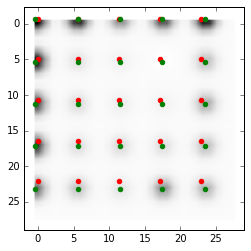

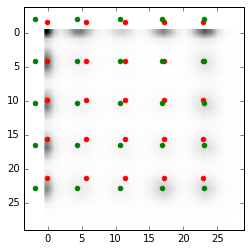

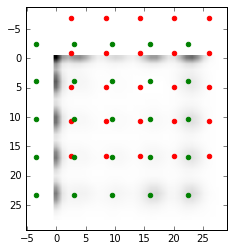

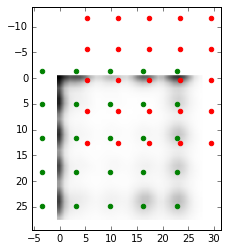

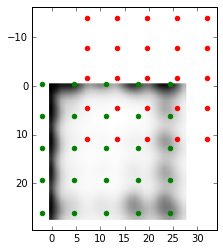

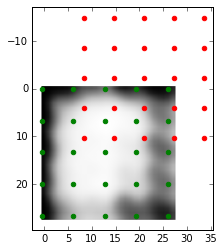

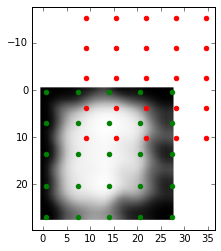

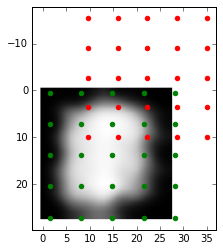

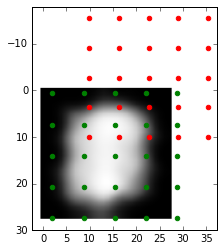

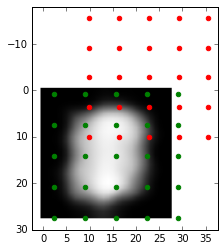

	Loss 15629.248047
Examples 301
	Loss 15337.814453
Examples 302
	Loss 15721.080078
Examples 303
	Loss 16372.296875
Examples 304
	Loss 15479.074219
Examples 305
	Loss 15220.784180
Examples 306
	Loss 15688.077148
Examples 307
	Loss 15429.810547
Examples 308
	Loss 15557.281250
Examples 309
	Loss 15578.595703
Examples 310
	Loss 15480.989258
Examples 311
	Loss 15361.720703
Examples 312
	Loss 15328.593750
Examples 313
	Loss 14927.281250
Examples 314
	Loss 14638.298828
Examples 315
	Loss 15323.069336
Examples 316
	Loss 15055.112305
Examples 317
	Loss 15117.991211
Examples 318
	Loss 15338.156250
Examples 319
	Loss 14327.571289
Examples 320


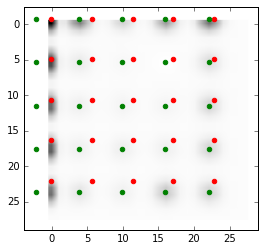

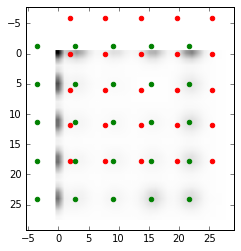

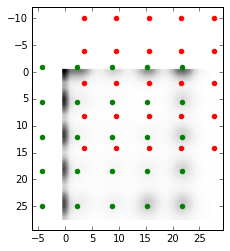

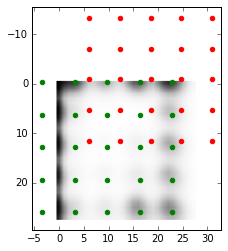

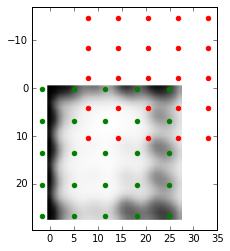

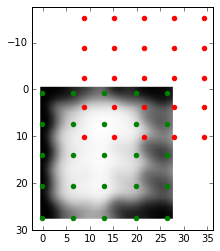

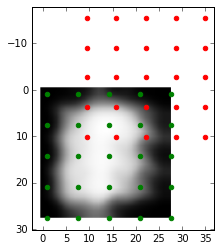

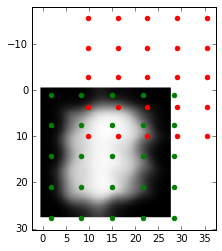

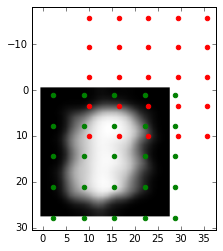

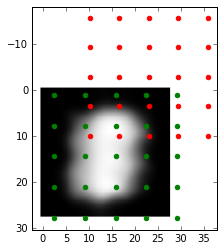

	Loss 14708.578125
Examples 321
	Loss 14949.151367
Examples 322
	Loss 14937.981445
Examples 323
	Loss 15171.528320
Examples 324
	Loss 14873.726562
Examples 325
	Loss 14509.901367
Examples 326
	Loss 14740.583008
Examples 327
	Loss 15215.927734
Examples 328
	Loss 15156.381836
Examples 329
	Loss 15176.610352
Examples 330
	Loss 14785.324219
Examples 331
	Loss 15291.636719
Examples 332
	Loss 15672.395508
Examples 333
	Loss 14484.234375
Examples 334
	Loss 15062.541016
Examples 335
	Loss 14446.182617
Examples 336
	Loss 15288.513672
Examples 337
	Loss 14779.541016
Examples 338
	Loss 15022.982422
Examples 339
	Loss 15359.223633
Examples 340


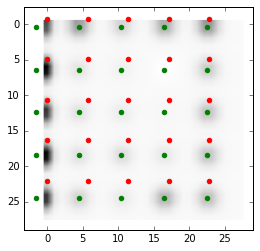

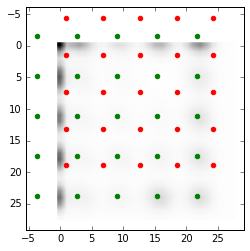

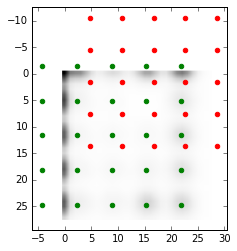

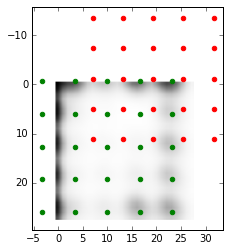

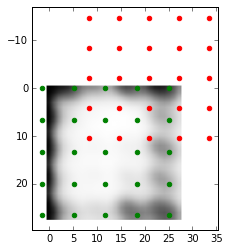

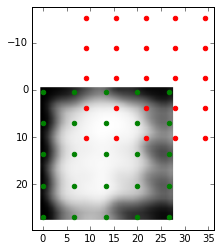

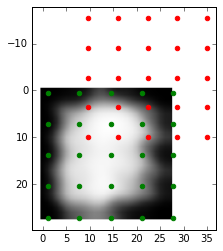

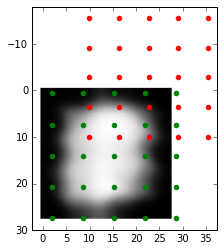

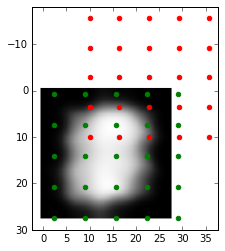

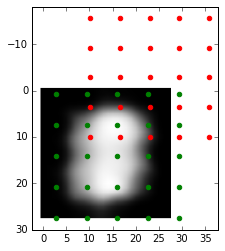

	Loss 15055.369141
Examples 341
	Loss 15398.799805
Examples 342
	Loss 14834.405273
Examples 343
	Loss 14974.903320
Examples 344
	Loss 14556.437500
Examples 345
	Loss 14862.765625
Examples 346
	Loss 15433.284180
Examples 347
	Loss 14910.093750
Examples 348
	Loss 14425.672852
Examples 349
	Loss 14790.746094
Examples 350
	Loss 14783.331055
Examples 351
	Loss 15433.329102
Examples 352
	Loss 15054.867188
Examples 353
	Loss 15404.666992
Examples 354
	Loss 15717.630859
Examples 355
	Loss 14539.802734
Examples 356
	Loss 14387.455078
Examples 357
	Loss 14974.228516
Examples 358
	Loss 14679.917969
Examples 359
	Loss 14613.225586
Examples 360


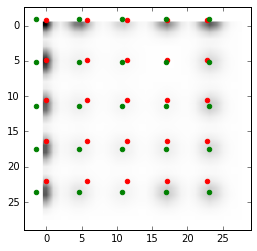

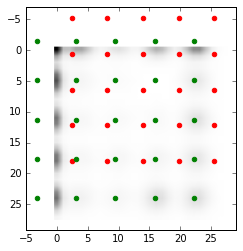

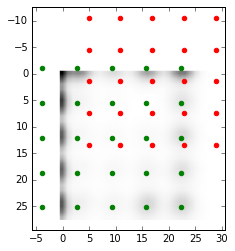

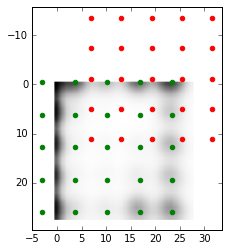

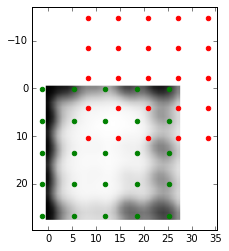

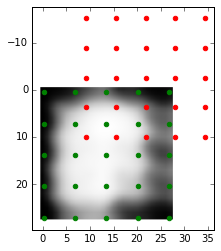

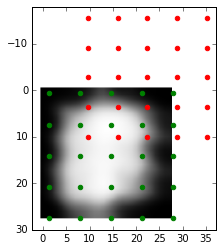

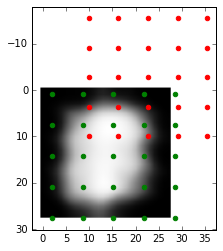

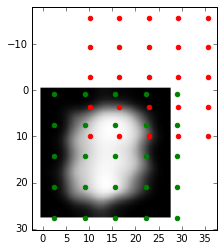

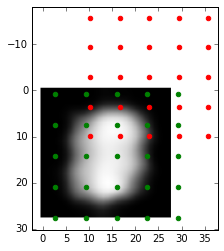

	Loss 15164.486328
Examples 361
	Loss 15100.230469
Examples 362
	Loss 14673.166016
Examples 363
	Loss 14727.294922
Examples 364
	Loss 15155.261719
Examples 365
	Loss 15092.314453
Examples 366
	Loss 15077.970703
Examples 367
	Loss 14689.727539
Examples 368
	Loss 14732.873047
Examples 369
	Loss 14878.023438
Examples 370
	Loss 15046.302734
Examples 371
	Loss 14892.296875
Examples 372
	Loss 14839.122070
Examples 373
	Loss 14577.828125
Examples 374
	Loss 14376.338867
Examples 375
	Loss 14724.538086
Examples 376
	Loss 14715.107422
Examples 377
	Loss 14334.303711
Examples 378
	Loss 14635.111328
Examples 379
	Loss 15095.577148
Examples 380


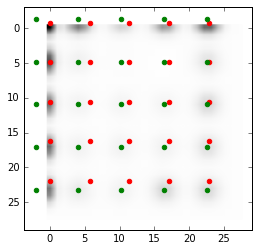

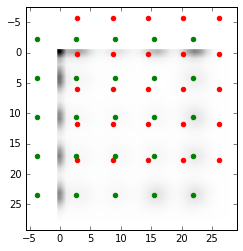

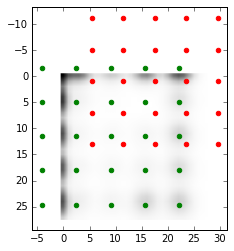

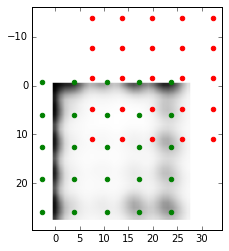

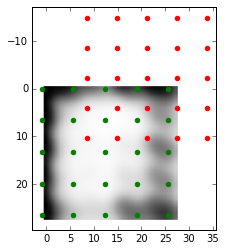

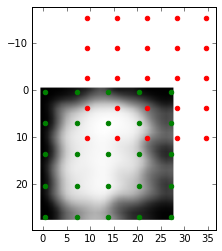

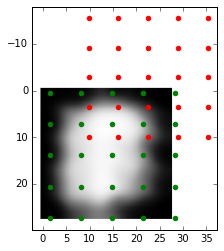

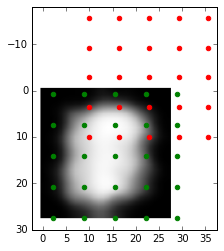

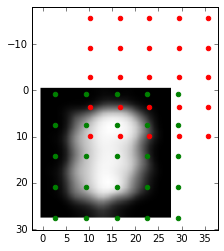

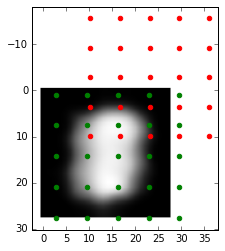

	Loss 14864.657227
Examples 381
	Loss 14794.447266
Examples 382
	Loss 14581.497070
Examples 383
	Loss 14643.064453
Examples 384
	Loss 14245.288086
Examples 385
	Loss 14735.282227
Examples 386
	Loss 14765.861328
Examples 387
	Loss 14278.817383
Examples 388
	Loss 14636.976562
Examples 389
	Loss 14468.533203
Examples 390
	Loss 14402.546875
Examples 391
	Loss 14800.360352
Examples 392
	Loss 14692.232422
Examples 393
	Loss 15192.375000
Examples 394
	Loss 14893.750000
Examples 395
	Loss 15210.630859
Examples 396
	Loss 15681.993164
Examples 397
	Loss 14907.993164
Examples 398
	Loss 14514.666992
Examples 399
	Loss 15024.019531
Examples 400


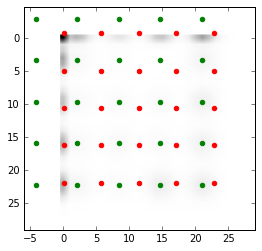

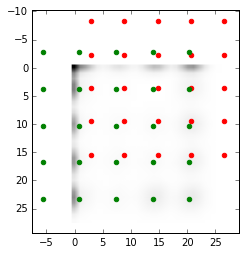

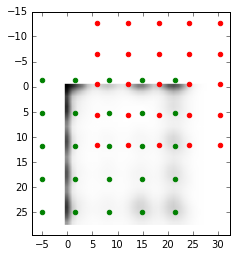

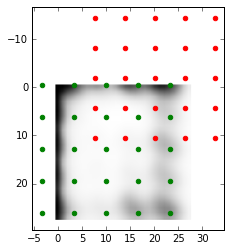

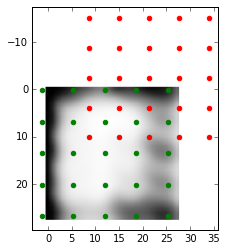

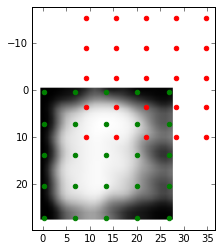

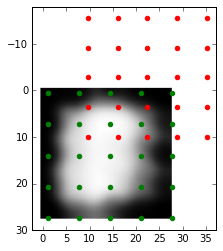

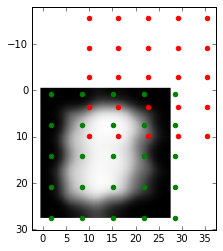

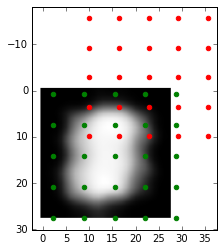

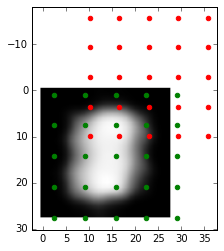

	Loss 14959.400391
Examples 401
	Loss 15056.296875
Examples 402
	Loss 14357.628906
Examples 403
	Loss 14389.947266
Examples 404
	Loss 14065.995117
Examples 405
	Loss 14434.235352
Examples 406
	Loss 14668.180664
Examples 407
	Loss 14141.380859
Examples 408
	Loss 14239.135742
Examples 409
	Loss 14490.028320
Examples 410
	Loss 14329.843750
Examples 411
	Loss 14770.532227
Examples 412
	Loss 13955.339844
Examples 413
	Loss 14487.984375
Examples 414
	Loss 13960.231445
Examples 415
	Loss 14399.947266
Examples 416
	Loss 14158.552734
Examples 417
	Loss 15765.277344
Examples 418
	Loss 13753.287109
Examples 419
	Loss 14468.502930
Examples 420


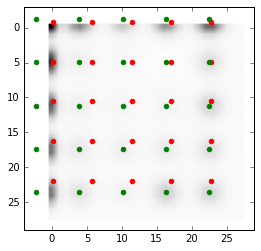

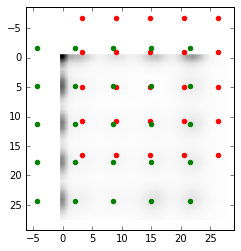

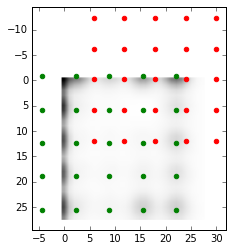

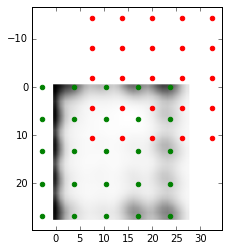

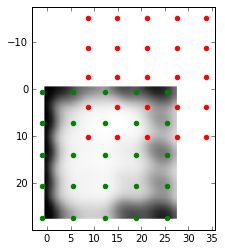

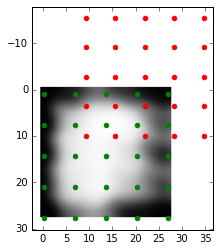

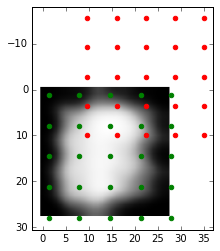

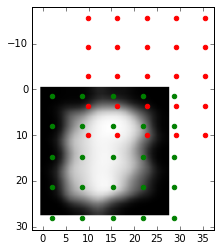

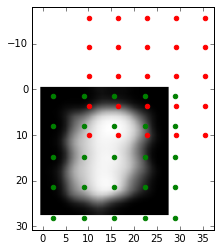

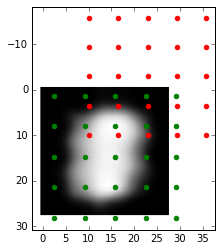

	Loss 14201.252930
Examples 421
	Loss 14749.933594
Examples 422
	Loss 14935.639648
Examples 423
	Loss 14683.867188
Examples 424
	Loss 14393.261719
Examples 425
	Loss 14626.429688
Examples 426
	Loss 14240.154297
Examples 427
	Loss 14374.173828
Examples 428
	Loss 14021.263672
Examples 429
	Loss 14630.005859
Examples 430
	Loss 14775.592773
Examples 431
	Loss 14690.073242
Examples 432
	Loss 14149.349609
Examples 433
	Loss 14812.035156
Examples 434
	Loss 13893.583984
Examples 435
	Loss 13337.084961
Examples 436
	Loss 14936.127930
Examples 437
	Loss 14570.555664
Examples 438
	Loss 14014.355469
Examples 439
	Loss 15377.398438
Examples 440


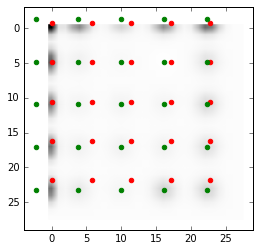

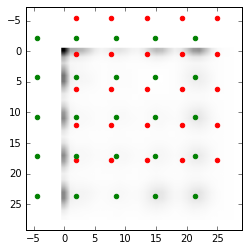

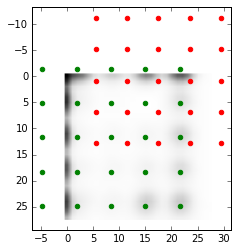

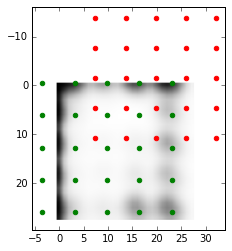

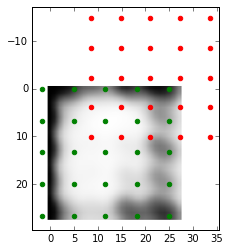

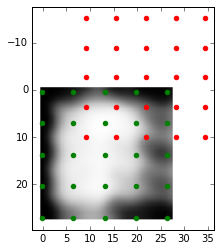

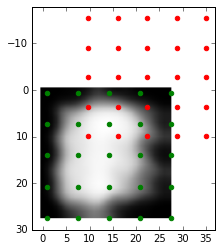

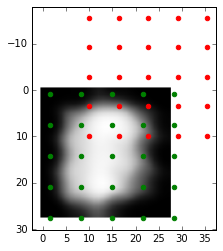

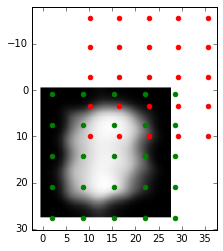

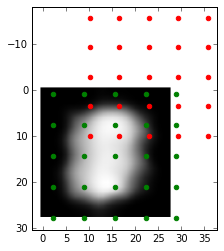

	Loss 14196.598633
Examples 441
	Loss 14860.595703
Examples 442
	Loss 14676.257812
Examples 443
	Loss 14732.953125
Examples 444
	Loss 14081.978516
Examples 445
	Loss 14612.795898
Examples 446
	Loss 13878.097656
Examples 447
	Loss 13933.883789
Examples 448
	Loss 14462.739258
Examples 449
	Loss 13943.693359
Examples 450
	Loss 14350.197266
Examples 451
	Loss 15572.176758
Examples 452
	Loss 14512.944336
Examples 453
	Loss 14309.702148
Examples 454
	Loss 15090.020508
Examples 455
	Loss 14473.818359
Examples 456
	Loss 14381.477539
Examples 457
	Loss 14537.262695
Examples 458
	Loss 14186.476562
Examples 459
	Loss 13884.739258
Examples 460


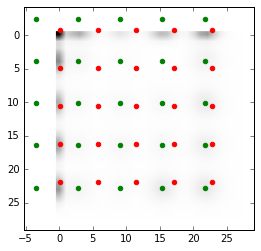

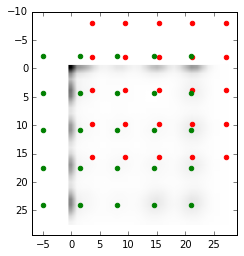

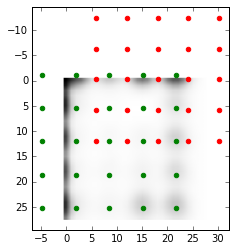

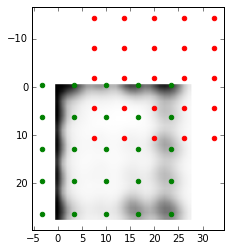

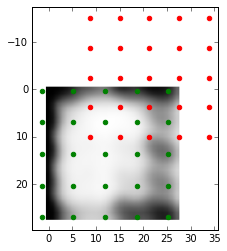

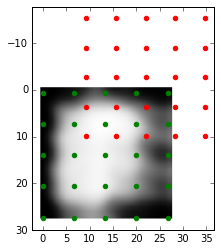

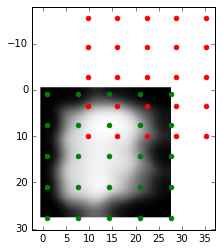

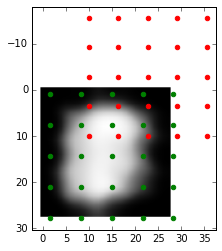

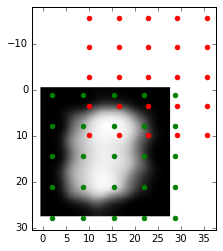

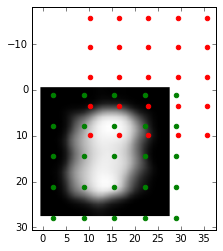

	Loss 14482.540039
Examples 461
	Loss 13830.054688
Examples 462
	Loss 14249.271484
Examples 463
	Loss 14304.680664
Examples 464
	Loss 13915.253906
Examples 465
	Loss 14812.702148
Examples 466
	Loss 14389.626953
Examples 467
	Loss 13788.264648
Examples 468
	Loss 14830.208008
Examples 469
	Loss 14463.474609
Examples 470
	Loss 14012.317383
Examples 471
	Loss 14702.219727
Examples 472
	Loss 14106.301758
Examples 473
	Loss 14509.716797
Examples 474
	Loss 13826.210938
Examples 475
	Loss 14301.920898
Examples 476
	Loss 14331.121094
Examples 477
	Loss 14572.487305
Examples 478
	Loss 13909.788086
Examples 479
	Loss 14334.631836
Examples 480


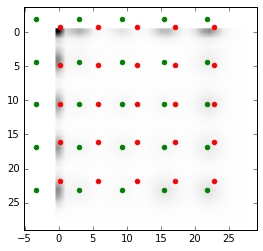

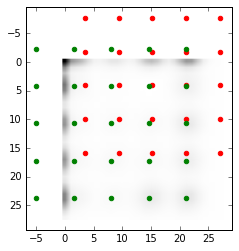

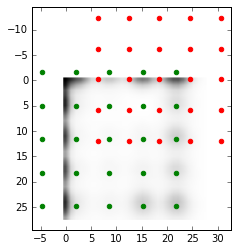

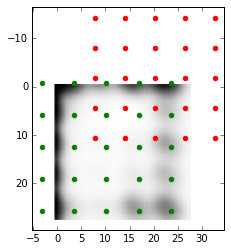

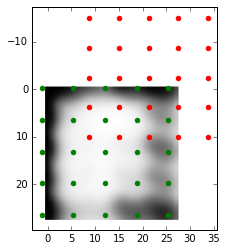

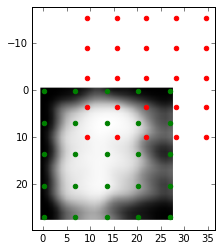

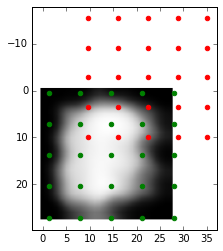

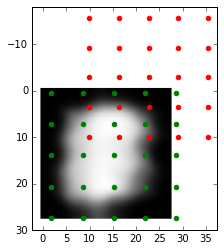

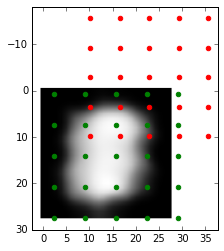

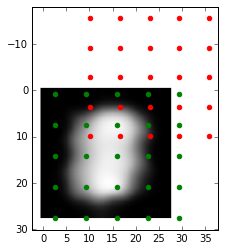

	Loss 14284.620117
Examples 481
	Loss 14166.351562
Examples 482
	Loss 14717.933594
Examples 483
	Loss 14105.734375
Examples 484
	Loss 14618.179688
Examples 485
	Loss 14221.498047
Examples 486
	Loss 14515.580078
Examples 487
	Loss 13422.592773
Examples 488
	Loss 14231.366211
Examples 489
	Loss 13905.105469
Examples 490
	Loss 14164.708008
Examples 491
	Loss 14084.958008
Examples 492
	Loss 13771.346680
Examples 493
	Loss 13849.215820
Examples 494
	Loss 13870.077148
Examples 495
	Loss 13871.601562
Examples 496
	Loss 14195.016602
Examples 497
	Loss 14194.006836
Examples 498
	Loss 14844.662109
Examples 499
	Loss 14426.697266
Examples 500


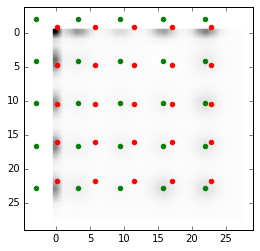

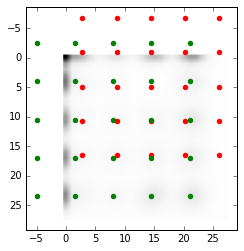

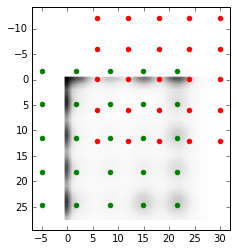

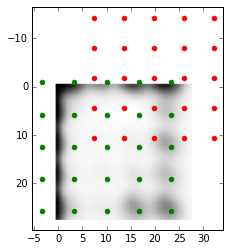

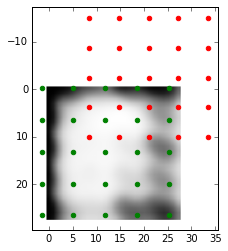

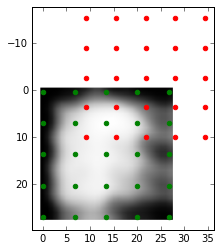

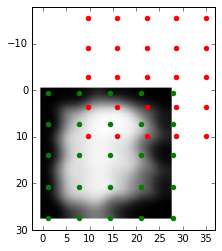

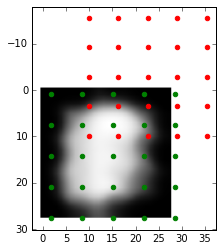

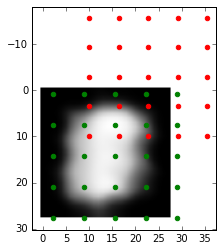

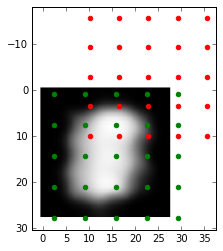

	Loss 14482.575195
Examples 501
	Loss 14178.967773
Examples 502
	Loss 13898.480469
Examples 503
	Loss 13938.244141
Examples 504
	Loss 13907.395508
Examples 505
	Loss 14013.217773
Examples 506


In [ ]:
print("Training...")
print("Attention: %r" % attention)
losses_log = []
latent_losses_log = []

num_batches = 10000

for i in range(num_batches):
    print("Examples %i" % i)
    imgs, ys = mnist.train.next_batch(batch_size)
    l, t_op, ll, cv, lmsout, lssout, ccd, sig, stri, ccdw, sigw, striw = sess.run([loss,  train_op, loss_latent, canvas, lms, lss, center_coords_decoded, sigma_decoded, stride_decoded, center_coords_decoded_write, sigma_decoded_write, stride_decoded_write], feed_dict = {x:imgs})
    
    if i % 20 == 0: # Do the plotting on every 20 batches
        for t in range(len(cv)):
            c = cv[t][-1] # Last batch of each time step
            c_img = MNIST_row_as_image(c.tolist())
            plt.figure()
            plt.imshow(c_img, cmap = cm.Greys_r)

            filter_bank_X, filter_bank_Y, means = np_get_filter_banks(center_coords_dec = ccd[t], sigma_dec = sig[t], stride_dec = stri[t], N = N_read)
            filter_bank_Xw, filter_bank_Yw, meansw = np_get_filter_banks(center_coords_dec = ccdw[t], sigma_dec = sigw[t], stride_dec = striw[t], N = N_write)
            if attention:
                scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
                scat2 = plt.scatter([m[0] for m in meansw], [m[1] for m in meansw], color = 'g')
            plt.show()

    losses_log.append(l)
    latent_losses_log.append(ll)
    print("\tLoss %f" % l)

In [ ]:
plt.figure()
plt.title("Training loss")

conv_size = 1
def smooth(ser):
    return np.convolve(ser, np.ones((conv_size,))/conv_size, mode='valid')

plt.plot(smooth(losses_log), label = "loss (reconstruction + latent)")
plt.legend()
plt.figure()
plt.plot(smooth(latent_losses_log), label = "latent loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(smooth([losses_log[k] - relative_weight*latent_losses_log[k] for k in range(len(losses_log))][:]), label = "reconstruction loss")
plt.legend()

plt.show()

In [ ]:
imgs = []
for b in range(batch_size):
    imgs.append(mnist.train.images[32100+b][:])

print("Trained model...")
l, cv, lmsout, lssout, ccd, sig, stri, ccdw, sigw, striw = sess.run([loss, canvas, lms, lss, center_coords_decoded, sigma_decoded, stride_decoded, center_coords_decoded_write, sigma_decoded_write, stride_decoded_write], feed_dict = {x:imgs})

for t in range(len(cv)):
    c = cv[t][-1] # Last batch of each time step
    c_img = MNIST_row_as_image(c.tolist())
    plt.figure()
    plt.imshow(c_img, cmap = cm.Greys_r)

    filter_bank_X, filter_bank_Y, means = np_get_filter_banks(center_coords_dec = ccd[t], sigma_dec = sig[t], stride_dec = stri[t], N = N_read)
    filter_bank_Xw, filter_bank_Yw, meansw = np_get_filter_banks(center_coords_dec = ccdw[t], sigma_dec = sigw[t], stride_dec = striw[t], N = N_write)
    if attention:
        scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
        scat2 = plt.scatter([m[0] for m in meansw], [m[1] for m in meansw], color = 'g')
    plt.show()